# Prediction 


In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval
# is used for safely evaluating strings containing Python literals or container displays
# (e.g., lists, dictionaries) to their corresponding Python objects.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [84]:
import pandas as pd

file_path = r"C:\Users\ghrib\OneDrive\Desktop\ProjectsAI\Papersrecommendationsystem\papersdata.xlsx"

data = pd.read_excel(file_path)

# Display the first few rows of the DataFrame to verify the import
data.head()


,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [85]:
data.shape

(51774, 3)

### Data Preprocessing 


In [5]:
data.duplicated().sum()

12783

In [86]:
data['terms'].value_counts()

terms
['cs.CV']                                                            17369
['cs.LG', 'stat.ML']                                                  5251
['cs.LG']                                                             2732
['cs.CV', 'cs.LG']                                                    2067
['cs.LG', 'cs.AI']                                                    1702
                                                                     ...  
['cs.LG', 'stat.ML', 'I.6.4; I.5.3; I.4.6; I.2.4']                       1
['cs.LG', 'math.ST', 'stat.ML', 'stat.TH', '62H22, 62R01, 62J99']        1
['cs.LG', 'cs.RO', 'math.ST', 'stat.TH']                                 1
['cs.LG', 'cs.AI', 'cs.DS', '68T01, 68T09', 'I.2.6; I.5.1']              1
['stat.ML', 'cs.CV', 'cs.LG', 'q-bio.QM']                                1
Name: count, Length: 3157, dtype: int64

essentially extracting the 'terms' column from the DataFrame, applying literal_eval to convert string representations of lists into actual lists, exploding the lists into separate rows, and then obtaining the unique labels. Finally, it prints both the unique labels and the length of the set of unique labels. This process helps in understanding the variety and distribution of labels in the 'terms' column after handling the string representations of lists and exploding them.

In [6]:
# getting unique labels
labels_column = data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("length :",len(labels))

labels : ['cs.CV' 'cs.LG' 'cs.AI' ... 'I.2.6; I.5.1; G.3'
 '92E10, 46M20, 94A08, 68U10, 44A12, 55R35' '92E10']
length : 1099


In [7]:
# remove duplicate entries based on the "titles" (terms) column
# This filters the DataFrame, keeping only the rows where the titles are not duplicated.
data = data[~data['titles'].duplicated()]
print(f"There are {len(data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(data['terms'].value_counts()==1))
# how many unique terms
print(data['terms'].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


Issue Addressed: The dataset originally had duplicated entries based on the 'titles' column. The code removes these duplicates, leaving only unique entries. This helps in avoiding redundancy and ensures that each research paper is represented only once.


In [8]:
# Filtering the rare terms. (it keeps only those rows where the "terms" value occurs more than once in the original DataFrame.)
data_filtered = data.groupby('terms').filter(lambda x: len(x) > 1)
data_filtered.shape

(36651, 3)


Issue Addressed: This code filters out rows where the 'terms' value occurs only once in the original dataset. Rare terms (those occurring only once) might not provide enough information for meaningful analysis or recommendation. By focusing on terms that occur more than once, the code helps to filter out noise and ensures that the analysis is based on terms with sufficient representation in the dataset.

In [9]:
# It evaluates the given string containing a Python literal or container display (e.g., a list or dictionary) and returns the corresponding Python object.
data_filtered['terms'] = data_filtered['terms'].apply(lambda x: literal_eval(x))
data_filtered['terms'].values[:3]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI'])], dtype=object)

### Train / Test Split

In [46]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(data_filtered,test_size=test_split,stratify=data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


In [11]:
# creates a TensorFlow RaggedTensor (terms) from the values in the "terms" column of the train_df DataFrame. A RaggedTensor is a tensor with non-uniform shapes
terms = tf.ragged.constant(train_df['terms'].values)
# This line creates a StringLookup layer in TensorFlow. The purpose of this layer is to map strings to integer indices and vice versa. The output_mode="multi_hot" indicates that the layer will output a multi-hot encoded representation of the input strings.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
# This step adapts the StringLookup layer to the unique values in the "terms" column, building the vocabulary.
lookup.adapt(terms)
# retrieve vocabulary
vocab = lookup.get_vocabulary()

print("Vocabulary:\n")
print(vocab)



Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.SE', 'cs.NI', 'cs.CG', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.PL', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'physics.comp-ph', 'I.2.10', 'cs.CE', 'cs.AR', 'q-fin.ST', 'cond-mat.stat-mech', '68T05', 'math.DS', 'cs.CC', 'quant-ph', 'I.4.6', 'physics.data-an', 'physics.soc-ph', 'physics.ao-ph', 'econ.EM', 'cs.DM', 'q-bio.GN', 'physics.med-ph', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.PF', 'I.4', 'q-fin.TR', 'cs.FL', 'I.5.4', 'I.2', '68U10', 'physics.geo-ph', 'hep-ex', '68T10', 'cond-mat.mtrl-sci', 'physics.optics', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', 'I.2.10; I.

In [13]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'cs.AI', 'cs.CL', 'cs.RO']
Label-binarized representation: [[0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [47]:
# following lines::
# which is used for automatic adjustment of resource usage by TensorFlow's data loading pipeline.

#max_seqlen: Maximum sequence length. It indicates the maximum length allowed for sequences.
max_seqlen = 150
#batch_size: Batch size. It specifies the number of samples to use in each iteration.
batch_size = 128
#padding_token: A token used for padding sequences.
padding_token = "<pad>"
#auto = tf.data.AUTOTUNE: auto is assigned the value tf.data.AUTOTUNE,
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    # creating sequences of labesls
    labels = tf.ragged.constant(dataframe["terms"].values)
    #This line uses the previously defined lookup layer to convert the ragged tensor of labels into a binarized representation. The resulting label_binarized is a NumPy array.
    label_binarized = lookup(labels).numpy()
    # creating sequences of text.
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["summaries"].values, label_binarized))
    # shuffling data basis on condition
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In summary, this code prepares a TensorFlow dataset for training a machine learning model. It processes sequences of labels and text, applies binarization to the labels, and performs shuffling and batching based on the provided parameters. The make_dataset function is likely to be used in the training loop to iterate over batches of data during model training.

In [50]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [51]:
# This code snippet is iterating through batches of the training dataset and printing the abstract text along with the corresponding labels.
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    #print(f"Label(s): {invert_multi_hot(label[0])}")
    print(label)

Abstract: b'Interactive theorem proving is a challenging and tedious process, which\nrequires non-trivial expertise and detailed low-level instructions (or tactics)\nfrom human experts. Tactic prediction is a natural way to automate this\nprocess. Existing methods show promising results on tactic prediction by\nlearning a deep neural network (DNN) based model from proofs written by human\nexperts. In this paper, we propose NeuroTactic, a novel extension with a\nspecial focus on improving the representation learning for theorem proving.\nNeuroTactic leverages graph neural networks (GNNs) to represent the theorems\nand premises, and applies graph contrastive learning for pre-training. We\ndemonstrate that the representation learning of theorems is essential to\npredict tactics. Compared with other methods, NeuroTactic achieves\nstate-of-the-art performance on the CoqGym dataset.'
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [36]:
# This code calculates the size of the vocabulary in the "abstracts" column of the train_df DataFrame.

# Creating vocabulary with uniques words
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153289


In summary, the "terms" vocabulary is crucial for the multi-label classification/prediction task, while the "abstracts" vocabulary is versatile and can be used for various NLP tasks to understand and process the textual content of the research papers.

### Text Vectorization 

In [52]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf")
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [53]:
"""
Mapping Vectorization to Datasets: The code maps the text vectorization operation to 
each element of the training, validation, and test datasets. This ensures that the text
data in each dataset is transformed into numerical vectors using the adapted TextVectorization layer.
The num_parallel_calls parameter is used to parallelize the mapping process, and prefetch is 
applied to prefetch data batches 
for better performance.
"""
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

### Model Training 

In [55]:
# creating shallow_mlp_model  (MLP)
from tensorflow.keras.callbacks import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])

Epoch 1/20
258/258 [==============================] - 243s 841ms/step - loss: 0.0510 - binary_accuracy: 0.9827 - val_loss: 0.0199 - val_binary_accuracy: 0.9941
Epoch 2/20
258/258 [==============================] - 187s 723ms/step - loss: 0.0185 - binary_accuracy: 0.9947 - val_loss: 0.0192 - val_binary_accuracy: 0.9942
Epoch 3/20
258/258 [==============================] - 182s 704ms/step - loss: 0.0143 - binary_accuracy: 0.9957 - val_loss: 0.0193 - val_binary_accuracy: 0.9941
Epoch 4/20
258/258 [==============================] - 182s 702ms/step - loss: 0.0118 - binary_accuracy: 0.9964 - val_loss: 0.0203 - val_binary_accuracy: 0.9941
Epoch 5/20
258/258 [==============================] - 181s 700ms/step - loss: 0.0101 - binary_accuracy: 0.9970 - val_loss: 0.0211 - val_binary_accuracy: 0.9941
Epoch 6/20
258/258 [==============================] - 181s 699ms/step - loss: 0.0090 - binary_accuracy: 0.9974 - val_loss: 0.0217 - val_binary_accuracy: 0.9940
Epoch 7/20
258/258 [====================

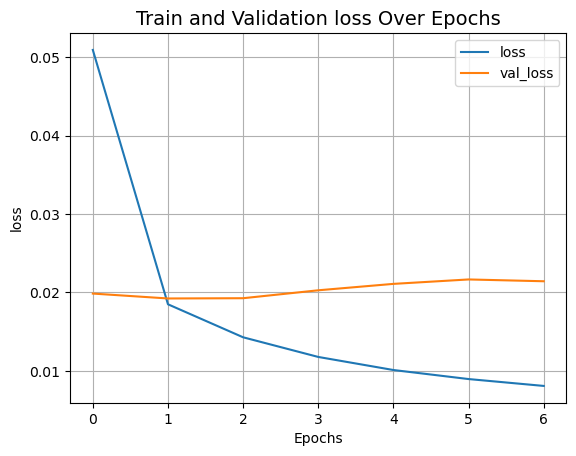

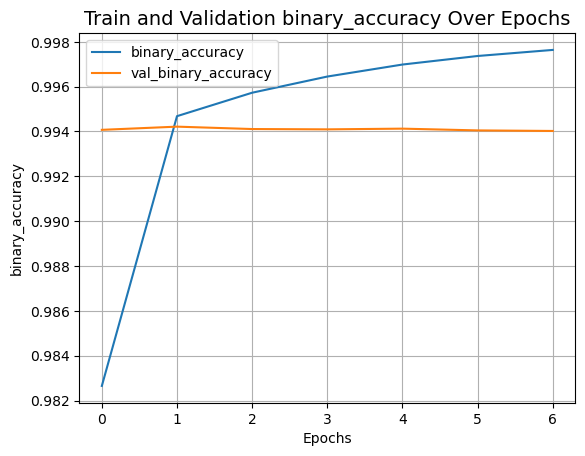

In [58]:
# plotting loss
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")


### Model Evalution 

In [59]:
# model evaltuation on test and val dataset
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

15/15 [==============================] - 4s 127ms/step - loss: 0.0192 - binary_accuracy: 0.9942
Categorical accuracy on the test set: 99.43%.
Categorical accuracy on the validation set: 99.42%.


### Save Model and Text Vectorizer 

In [63]:
import pickle



In [64]:
# Save the model
model1.save("models/model.h5")

# Save the configuration of the text vectorizer
saved_text_vectorizer_config = text_vectorizer.get_config()
with open("models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_config, f)


# Save the vocabulary
with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

### Load Model 

In [ ]:
from tensorflow import keras
import pickle

# Load the model
loaded_model = keras.models.load_model("models/model.h5")

from tensorflow.keras.layers import TextVectorization

# Load the configuration of the text vectorizer
with open("models/text_vectorizer_config.pkl", "rb") as f:
    saved_text_vectorizer_config = pickle.load(f)

# Create a new TextVectorization layer with the saved configuration
loaded_text_vectorizer = TextVectorization.from_config(saved_text_vectorizer_config)

# Load the saved weights into the new TextVectorization layer
with open("models/text_vectorizer_weights.pkl", "rb") as f:
    weights = pickle.load(f)
    loaded_text_vectorizer.set_weights(weights)

In [30]:
# Load the vocabulary
with open("models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)

### Model Prediction

In [68]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(loaded_vocab, hot_indices)

In [69]:
def predict_category(abstract, model, vectorizer, label_lookup):
    # Preprocess the abstract using the loaded text vectorizer
    preprocessed_abstract = vectorizer([abstract])

    # Make predictions using the loaded model
    predictions = model.predict(preprocessed_abstract)

    # Convert predictions to human-readable labels
    predicted_labels = label_lookup(np.round(predictions).astype(int)[0])

    return predicted_labels

# Recommendation System

In [87]:
data1 = data.copy()

In [88]:
data1.columns

Index(['titles', 'summaries', 'terms'], dtype='object')

In [91]:
data1.drop(columns = ["terms","summaries"], inplace = True)

In [92]:
data1.head()

,titles
0,Survey on Semantic Stereo Matching / Semantic ...
1,FUTURE-AI: Guiding Principles and Consensus Re...
2,Enforcing Mutual Consistency of Hard Regions f...
3,Parameter Decoupling Strategy for Semi-supervi...
4,Background-Foreground Segmentation for Interio...


In [93]:
data1.drop_duplicates(inplace= True)
data1.reset_index(drop= True,inplace = True)

### Sentence Tranformers

In [94]:
!pip install -U -q sentence-transformers


In [95]:
# This imports the SentenceTransformer class from the Sentence Transformers library.
from sentence_transformers import SentenceTransformer, util
# we load all-MiniLM-L6-v2, which is a MiniLM model fine tuned on a large dataset of over 
# 1 billion training pairs.
#This initializes the 'all-MiniLM-L6-v2' model from Sentence Transformers. 
# This model is capable of encoding sentences into fixed-size vectors (embeddings).
model = SentenceTransformer('all-MiniLM-L6-v2')
#Our sentences we like to encode
sentences = data1['titles']
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

"""
The embeddings can be used for various natural language processing (NLP) tasks, 
such as similarity search, clustering
"""

'\nThe embeddings can be used for various natural language processing (NLP) tasks, \nsuch as similarity search, clustering\n'

In [96]:
embeddings


array([[-3.73324454e-02, -5.35795698e-04, -4.86987159e-02, ...,
         4.00168449e-02, -8.07433389e-03, -1.12721249e-01],
       [-6.75695688e-02, -3.25633399e-02,  2.85482500e-02, ...,
         5.83392009e-02, -2.35455688e-02, -3.87291685e-02],
       [ 3.01970858e-02, -1.08644635e-04,  6.92958683e-02, ...,
         7.74509311e-02, -9.04723257e-02, -3.32056321e-02],
       ...,
       [-5.21421246e-02, -8.82680044e-02, -5.11411242e-02, ...,
        -6.05786592e-02,  5.92942983e-02, -2.94687860e-02],
       [-1.54422028e-02, -7.96080008e-02,  1.47850271e-02, ...,
         1.22725777e-02,  2.37942673e-02, -4.95932549e-02],
       [ 2.12829318e-02, -7.37964585e-02,  6.02626316e-02, ...,
         1.05841152e-01, -3.17206718e-02, -1.08712181e-01]], dtype=float32)

In [97]:
embeddings.shape

(38972, 384)

In [98]:
c = 0

for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding length:", len(embedding)) # list of floats
    print("")
    if c >=5:
        break
    c +=1 

Sentence: Survey on Semantic Stereo Matching / Semantic Depth Estimation
Embedding length: 384

Sentence: FUTURE-AI: Guiding Principles and Consensus Recommendations for Trustworthy Artificial Intelligence in Future Medical Imaging
Embedding length: 384

Sentence: Enforcing Mutual Consistency of Hard Regions for Semi-supervised Medical Image Segmentation
Embedding length: 384

Sentence: Parameter Decoupling Strategy for Semi-supervised 3D Left Atrium Segmentation
Embedding length: 384

Sentence: Background-Foreground Segmentation for Interior Sensing in Automotive Industry
Embedding length: 384

Sentence: EdgeFlow: Achieving Practical Interactive Segmentation with Edge-Guided Flow
Embedding length: 384



In [101]:
import pickle
# Saving sentences and corresponding embeddings
with open('models/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

with open('models/sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)
    
with open('models/rec_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [102]:
# load save files
embeddings = pickle.load(open('models/embeddings.pkl','rb'))
sentences = pickle.load(open('models/sentences.pkl','rb'))
rec_model = pickle.load(open('models/rec_model.pkl','rb'))

In [103]:
import torch

def recommendation(input_paper):
    # Calculate cosine similarity scores between the embeddings of input_paper and all papers in the dataset.
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))
    
    # Get the indices of the top-k most similar papers based on cosine similarity.
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)
                                 
    # Retrieve the titles of the top similar papers.
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list

In [104]:
# exampel usage 1: (use this paper as input (Attention is All you Need))
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

Enter the title of any paper you likeAttention is All you Need
We recommend to read this paper............
Attention that does not Explain Away
Area Attention
Pay Attention when Required
Long Short-Term Attention
Attention as Activation


In [106]:
# exampel usage 3: (use this paper as input (Review of deep learning: concepts, CNN architectures, challenges, applications, future directions))
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

Enter the title of any paper you likeReview of deep learning: concepts, CNN architectures, challenges, applications, future directions
We recommend to read this paper............
A Review of Deep Learning with Special Emphasis on Architectures, Applications and Recent Trends
Review of Deep Learning
Deep Convolutional Neural Networks: A survey of the foundations, selected improvements, and some current applications
A Survey of the Recent Architectures of Deep Convolutional Neural Networks
A Survey of Convolutional Neural Networks: Analysis, Applications, and Prospects
